### __Imports and installs__

In [1]:
from pathlib import Path
import subprocess
from tqdm import tqdm
import os
from IPython.display import display

import torch
from torch.utils.data import DataLoader

from utils_dataset import CustomImageDataset, deprocess_image, load_labels
from utils_plot import show_images, show_one_image, show_cams, show_one_cam, show_centers
from utils_cam import generate_cams
from utils_models import load_model, evaluate_model_accuracy, evaluate_cross_model_accuracy
from utils_adversarial import APD, save_adversarial_images

import pandas as pd


In [2]:
batch_size = 24
num_workers = 4

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### __Dataset__

In [3]:
models = []

resnet101 = load_model("resnet101")
models.append(resnet101)
inception_v3 = load_model("inception_v3")
models.append(inception_v3)
inception_v4 = load_model("inception_v4")
models.append(inception_v4)
adv_inception_v3 = load_model("adv_inception_v3")
models.append(adv_inception_v3)
inception_resnet_v2 = load_model("inception_resnet_v2")
models.append(inception_resnet_v2)


Loading model 'resnet101' from Model/resnet101.pth
Loading model 'inception_v3' from Model/inception_v3.pth
Loading model 'inception_v4' from Model/inception_v4.pth
Loading model 'adv_inception_v3' from Model/adv_inception_v3.pth
Loading model 'inception_resnet_v2' from Model/inception_resnet_v2.pth


In [4]:
images_folder_path = Path('tf_to_pytorch_model/dataset/images')
label_file_path = Path('tf_to_pytorch_model/dataset/dev_dataset.csv')

# Check if the images folder exists; if not, clone the repository
if not images_folder_path.exists():
    repo_url = 'https://github.com/ylhz/tf_to_pytorch_model.git'
    try:
        subprocess.run(["git", "clone", repo_url], check=True)
        print(f"Repository cloned successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {e}")


In [5]:
labels_dict = load_labels()

dataset = CustomImageDataset(label_file_path, images_folder_path)

dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)


Loading labels from imagenet_class_index.json


In [6]:
for model in models:
    evaluate_model_accuracy(model, dataloader, device)

### __Class Activation Maps__

In [7]:
# Show some images from the dataset

data_iter = iter(dataloader)
images, labels, _ = next(data_iter)

show_images(images, labels, labels_dict, rows=2)

In [8]:
# Show grad cams for some images for each model

for model in models:
    model.to(device)
    show_cams(model, images, labels, labels_dict, rows=2, image_weight=0.7)
    model.to('cpu')


In [9]:
# idx = 17
# for model in models:
#     print(model.name)
#     show_one_cam(model, images[idx], labels[idx], image_weight=0.7)

# show_one_image(images[idx])

### __Local Maxima__

In [10]:
images, labels, _ = next(iter(dataloader))

for model in models:
    show_centers(model, images, labels)

### __Main algorithm__

#### Example use

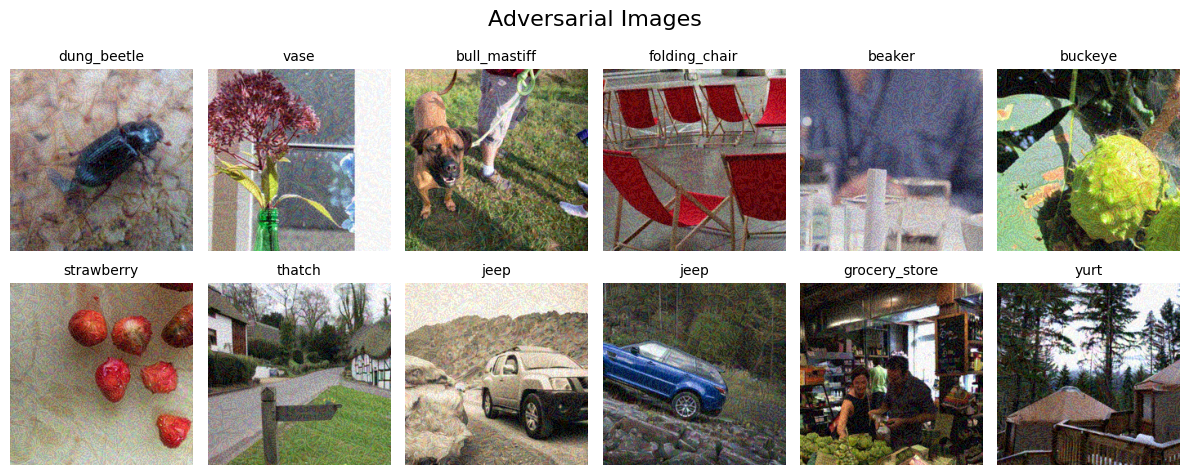

In [11]:
images, labels, _ = next(iter(dataloader))
model = resnet101

model.to(device)
x_adv = APD(images, labels, model)
model.to('cpu')

x_adv_dep = deprocess_image(x_adv)

show_images(x_adv_dep, labels, labels_dict, title="Adversarial Images")

In [12]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_apd")

Directory 'Generated/resnet101_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v3_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v4_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/adv_inception_v3_apd' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_resnet_v2_apd' already exists. Skipping adversarial image generation and saving.


In [13]:
df_pivot = evaluate_cross_model_accuracy(models, label_file_path, batch_size, num_workers, device, "_apd")
display(df_pivot)

df_pivot.to_csv("accuracies_apd.csv")

Evaluating:  98%|█████████▊| 41/42 [00:01<00:00, 44.16it/s]

Target Model,adv_inception_v3,inception_resnet_v2,inception_v3,inception_v4,resnet101
Base Model,,,,,
inception_resnet_v2,55.0,0.1,35.3,36.0,61.3
inception_v3,64.4,67.5,1.7,61.8,82.9
inception_v4,60.7,46.4,36.2,0.0,65.4
resnet101,56.2,48.8,39.6,41.9,0.3


In [ ]:
# # Try article way of getting centers:
# for model in models:
#     save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_apd_centers_article",
#                             method_centers="article")

In [ ]:
# df_pivot = evaluate_cross_model_accuracy(models, label_file_path, batch_size, num_workers, 
#                                          device, "_apd_centers_article")
# display(df_pivot)

# df_pivot.to_csv("accuracies_apd_centers_article.csv")

In [ ]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_mfgsm", attack_method="MFGSM")

Directory 'Generated/resnet101_mfgsm' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v3_mfgsm' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_v4_mfgsm' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/adv_inception_v3_mfgsm' already exists. Skipping adversarial image generation and saving.
Directory 'Generated/inception_resnet_v2_mfgsm' already exists. Skipping adversarial image generation and saving.


In [ ]:
df_pivot = evaluate_cross_model_accuracy(models, label_file_path, batch_size, num_workers, device, "_mfgsm")
display(df_pivot)

df_pivot.to_csv("accuracies_mfgsm.csv")

Target Model,adv_inception_v3,inception_resnet_v2,inception_v3,inception_v4,resnet101
Base Model,,,,,
inception_resnet_v2,42.9,0.0,27.9,29.3,52.7
inception_v3,39.5,0.1,0.0,15.7,37.6
inception_v4,40.6,0.2,14.6,0.0,41.2
resnet101,39.9,4.3,20.9,19.9,0.0


TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!);, Essayer moyenner x_adv sur différents modèles !!
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++ (done); threshold au lieu de région carrée pour régions dropout (done), tester en mettant le gradient à 0 dans les régions dropped out (done)